# RIGHT WING MEDIA DETECTION USING NLP MODEL 

The world is becoming more and more politically polarized. We saw how people made covid-19 vaccines a political issue during a pandemic than claimed millions of people, and how parents were complaining about their kids' curricula. Most newspapers identify as fair and unbiased, yet most of them keep contributing to this political polarization. Most readers visiting these newspapers websites or buying their hardcopies are doind so hoping that the news they get will be balanced. There is a void in finding a tool that can help these readers. That is the main focus for this project. We adapted the work done by Madhav Mathur on sarcasm detection.

So the question we are trying to answer is if it's possible for us to build a model that can help readers know the political bias of the news sources they read.

We use two models for making predictions namely `Word2Vec` and `GloVe Embeddings`. We then compare their results to see which model performs better.

We first import all relevant libraries.

In [1]:
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import re,string,unicodedata
from keras.preprocessing import text, sequence
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
from string import punctuation
import keras
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,Dropout,Bidirectional,GRU
import tensorflow as tf

Our first task was to acquire datasets. We were able to use two sets of datasets, one with 11 features and 93239 records, and another with 8 features and 680 records. 

In [2]:
df1 = pd.read_csv('News_Final.csv')
df2 = pd.read_csv('full_data.csv')

In [3]:
df1.head()

,IDLink,Title,Headline,Source,Topic,PublishDate,SentimentTitle,SentimentHeadline,Facebook,GooglePlus,LinkedIn
0,99248.0,Obama Lays Wreath at Arlington National Cemetery,Obama Lays Wreath at Arlington National Cemete...,USA TODAY,obama,2002-04-02 00:00:00,0.000000,-0.053300,-1,-1,-1
1,10423.0,A Look at the Health of the Chinese Economy,"Tim Haywood, investment director business-unit...",Bloomberg,economy,2008-09-20 00:00:00,0.208333,-0.156386,-1,-1,-1
2,18828.0,Nouriel Roubini: Global Economy Not Back to 2008,"Nouriel Roubini, NYU professor and chairman at...",Bloomberg,economy,2012-01-28 00:00:00,-0.425210,0.139754,-1,-1,-1
3,27788.0,Finland GDP Expands In Q4,Finland's economy expanded marginally in the t...,RTT News,economy,2015-03-01 00:06:00,0.000000,0.026064,-1,-1,-1
4,27789.0,"Tourism, govt spending buoys Thai economy in J...",Tourism and public spending continued to boost...,The Nation - Thailand&#39;s English news,economy,2015-03-01 00:11:00,0.000000,0.141084,-1,-1,-1


In [4]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93239 entries, 0 to 93238
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   IDLink             93239 non-null  float64
 1   Title              93239 non-null  object 
 2   Headline           93224 non-null  object 
 3   Source             92960 non-null  object 
 4   Topic              93239 non-null  object 
 5   PublishDate        93239 non-null  object 
 6   SentimentTitle     93239 non-null  float64
 7   SentimentHeadline  93239 non-null  float64
 8   Facebook           93239 non-null  int64  
 9   GooglePlus         93239 non-null  int64  
 10  LinkedIn           93239 non-null  int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 7.8+ MB


In [5]:
df2.head()

,Unnamed: 0,source,author,title,description,url,requested_date,publishedAt,content
0,0,The Verge,Nick Statt,Could this be Samsung’s bezel-less 8K TV?,"Samsung may have a new, groundbreaking type of...",https://www.theverge.com/circuitbreaker/2019/1...,2019-12-31,2019-12-31T22:48:35Z,Filed under:\r\nThe company is rumored to show...
1,0,The Verge,Zoe Schiffer,TikTok claims zero takedown requests from Chin...,"TikTok, owned by Chinese tech giant ByteDance,...",https://www.theverge.com/2019/12/31/21044876/t...,2019-12-31,2019-12-31T22:39:55Z,The highest number of requests came from India...
2,0,The Verge,Zoe Schiffer,Google will finally stop using controversial I...,The company saved tens of billions of dollars ...,https://www.theverge.com/2019/12/31/21044662/g...,2019-12-31,2019-12-31T20:11:26Z,Regulations will end the Double Irish and Dutc...
3,0,The Verge,Bijan Stephen,New Apple patent imagines virtual speakers tha...,Apple has just been granted a patent — concern...,https://www.theverge.com/2019/12/31/21044677/a...,2019-12-31,2019-12-31T19:02:11Z,Apple has filed patents for the tech in both h...
4,0,The Verge,Julia Alexander,Smoke app brings parts of Valve’s Steam to the...,A new third-party app called Smoke will bring ...,https://www.theverge.com/2019/12/31/21044379/a...,2019-12-31,2019-12-31T19:00:00Z,Check in on what friends are playing\r\nFor pe...


In [6]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 680 entries, 0 to 679
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Unnamed: 0      680 non-null    int64 
 1   source          680 non-null    object
 2   author          616 non-null    object
 3   title           680 non-null    object
 4   description     650 non-null    object
 5   url             680 non-null    object
 6   requested_date  680 non-null    object
 7   publishedAt     680 non-null    object
 8   content         621 non-null    object
dtypes: int64(1), object(8)
memory usage: 47.9+ KB


The first dataset had 5757 unique news sources while the second had 15 unique news sources.

In [7]:
len(df1['Source'].unique())

5757

In [8]:
len(df2['source'].unique())

15

In [9]:
df2['source'].unique()

array(['The Verge', 'CNN', 'The Hill', 'The New York Times',
       'The Huffington Post', 'Al Jazeera English', 'BBC News',
       'Independent', 'Reuters', 'Fox News', 'Breitbart News', 'ABC News',
       'Metro', 'Daily Mail', 'Mirror'], dtype=object)

Since one dataset had more than 5000 unique news sources while the other had only 15 unique sources, we found 13 common news sources that they share.

In [10]:
news_source = ['The Verge', 'CNN', 'The Hill', 'The New York Times',
       'The Huffington Post', 'BBC News',
       'Independent', 'Reuters', 'Fox News', 'Breitbart News', 'ABC News',
       'Metro', 'Daily Mail']

In [11]:
print(news_source)

['The Verge', 'CNN', 'The Hill', 'The New York Times', 'The Huffington Post', 'BBC News', 'Independent', 'Reuters', 'Fox News', 'Breitbart News', 'ABC News', 'Metro', 'Daily Mail']


In [12]:
df2 = df2.rename({'source': 'Source', 'title':'Title'}, axis=1)
df1['Source'].replace({'New York Times': 'The New York Times', 'Huffington Post': 'The Huffington Post','The Independent': 'Independent' }, inplace=True)

In [13]:
df1 = df1[df1['Source'].isin(news_source)]
df1.head()

,IDLink,Title,Headline,Source,Topic,PublishDate,SentimentTitle,SentimentHeadline,Facebook,GooglePlus,LinkedIn
14,27814.0,"HoloLens dev edition costs £2,000 with new Con...",Microsoft’s AR headset is being made available...,Metro,microsoft,2015-03-01 02:18:00,0.000000,0.079434,-1,-1,-1
26,80801.0,"Obama Encouraging Young People to Learn Math, ...",President Barack Obama is launching a version of,The New York Times,obama,2015-03-01 04:18:00,0.044194,-0.088388,-1,-1,-1
83,27974.0,"First Hololens kit to cost $3,000",Microsoft starts taking orders for the develop...,BBC News,microsoft,2015-03-01 09:53:00,0.097828,0.167038,-1,-1,-1
98,28014.0,Microsoft begins taking preorders from develop...,Microsoft has opened up preorder sales for its...,Daily Mail,microsoft,2015-03-01 12:18:00,0.208333,-0.095312,-1,-1,-1
142,69866.0,The First-Ever Raising of Palestine's Flag at ...,"Tomorrow, the Palestinian flag will be raised ...",The Huffington Post,palestine,2015-09-29 00:00:00,0.081857,0.194754,-1,-1,-1


In [14]:
df1.reset_index(inplace=True)

In [15]:
df1_new = df1[['Title', 'Source']]
df1_new.head()

,Title,Source
0,"HoloLens dev edition costs £2,000 with new Con...",Metro
1,"Obama Encouraging Young People to Learn Math, ...",The New York Times
2,"First Hololens kit to cost $3,000",BBC News
3,Microsoft begins taking preorders from develop...,Daily Mail
4,The First-Ever Raising of Palestine's Flag at ...,The Huffington Post


In [16]:
df2_new = df2[['Title', 'Source']]
df2_new.tail()

,Title,Source
675,Left Slams Trump for Protecting Americans and ...,Breitbart News
676,Ben Rhodes:Trump Foreign Policy 'Based on Obam...,Breitbart News
677,Biden Claims Trump Less Popular than Xi Jinpin...,Breitbart News
678,Top Ten #RedforEd Political Power Plays in 201...,Breitbart News
679,"New York City teen arrested for killing, robbi...",ABC News


We used those 13 unique news sources and the combined dataset to get a final dataset with 8805 records and two features, namely the `title` and the `source`.

In [17]:
df = pd.concat([df1_new, df2_new], ignore_index=True)
df.tail()

,Title,Source
8800,Left Slams Trump for Protecting Americans and ...,Breitbart News
8801,Ben Rhodes:Trump Foreign Policy 'Based on Obam...,Breitbart News
8802,Biden Claims Trump Less Popular than Xi Jinpin...,Breitbart News
8803,Top Ten #RedforEd Political Power Plays in 201...,Breitbart News
8804,"New York City teen arrested for killing, robbi...",ABC News


In [18]:
df.head()

,Title,Source
0,"HoloLens dev edition costs £2,000 with new Con...",Metro
1,"Obama Encouraging Young People to Learn Math, ...",The New York Times
2,"First Hololens kit to cost $3,000",BBC News
3,Microsoft begins taking preorders from develop...,Daily Mail
4,The First-Ever Raising of Palestine's Flag at ...,The Huffington Post


In [ ]:
df.info()

In order to build a political bias classifier, we used *All sides* chart and *Ad fontes media* chart and classified the 13 news sources into two categories. Below are the news sources from the right wing media, the rest are from left and center wing media.

In [20]:
right_media = [ 'The Hill', 'Fox News', 'Breitbart News', 'Metro', 'Daily Mail']

We then created a classifying feature `is_right` which takes a value 1 if the news source is from a right wing media and 0 otherwise.

In [21]:
df['is_right'] = df['Source'].isin(right_media).astype(int)
df['Title'] = df['Title'].apply(str.lower)

In [22]:
df.head()

,Title,Source,is_right
0,"hololens dev edition costs £2,000 with new con...",Metro,1
1,"obama encouraging young people to learn math, ...",The New York Times,0
2,"first hololens kit to cost $3,000",BBC News,0
3,microsoft begins taking preorders from develop...,Daily Mail,1
4,the first-ever raising of palestine's flag at ...,The Huffington Post,0


Unfortunately, oura data are unbalanced.

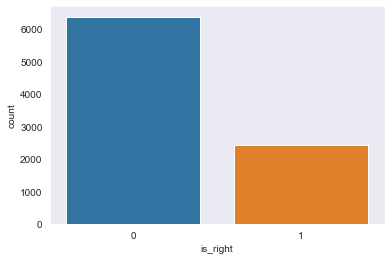

In [23]:
sns.set_style("dark")
sns.countplot(df.is_right)

In [24]:
class_0 = len(df[df['is_right'] == 0])
class_1 = len(df[df['is_right'] == 1])
ratio = class_0 /class_1
print(ratio)

2.6279357231149567


In [25]:
df['is_right'].value_counts()

0    6378
1    2427
Name: is_right, dtype: int64

In order to build a functional NLP model, our dataset pre-processing included removing `stopwords`,lowercasing our texts, removing noisy texts and tokenizing our texts

In [26]:
stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)

But before doing tokeniziation, and build a model, let's do some EDAs. First we realized that in our text data, the word `obama`, `economy` and `trump` were predominant in the news sources from the right wing media.

### WORDCLOUD for Text from Right Media

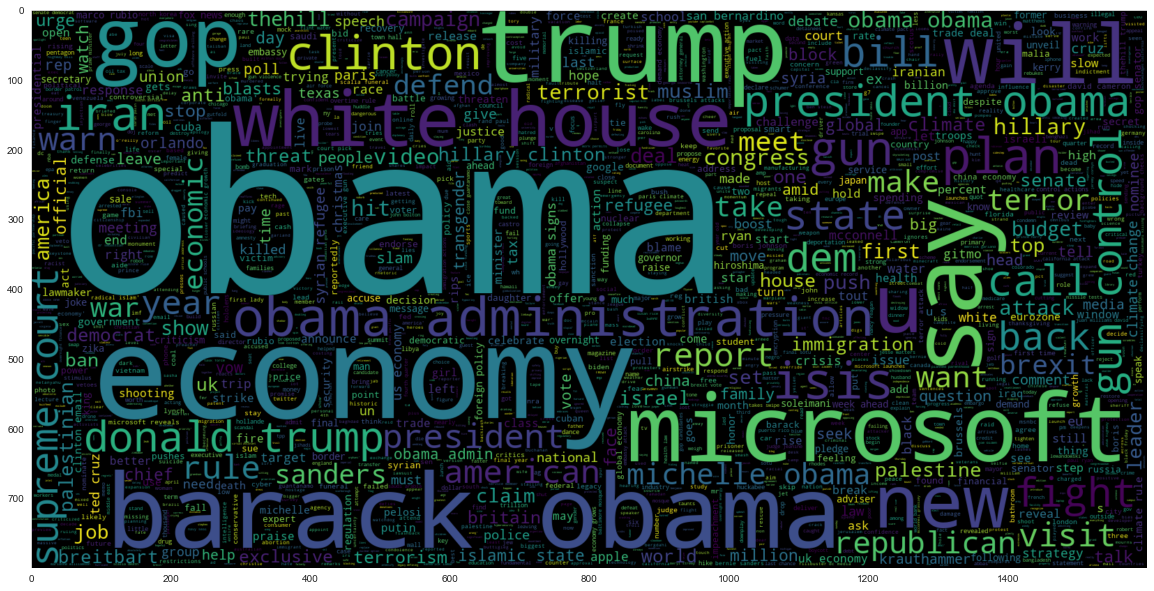

In [27]:
# Wordcloud for text from right media (label 1)
plt.figure(figsize = (20,20)) # Text that is non Sarcastic
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.is_right == 1].Title))
plt.imshow(wc , interpolation = 'bilinear')

### WORDCLOUD for Text from Left/Center Media

Surprisingly, the word `obama`, `economy` and `microsoft` (finally!) were predominant in the news sources from the left wing/center media.

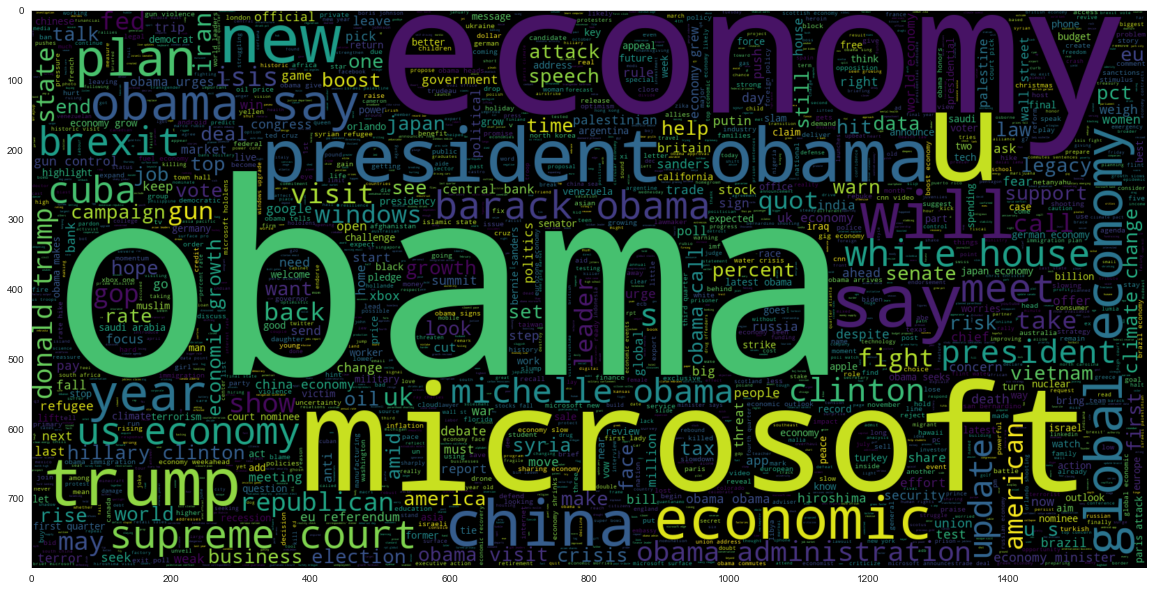

In [28]:
# Wordcloud for text from left/center media (label 0)
plt.figure(figsize = (20,20)) # Text that is non Sarcastic
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.is_right == 0].Title))
plt.imshow(wc , interpolation = 'bilinear')

We also see that in either news sources most texts have about 60 characters per text.The number of words in each text vary least in right center media than otherwise, with average word length in a text in each category varying almost similarly.

### Number of Characters in Text

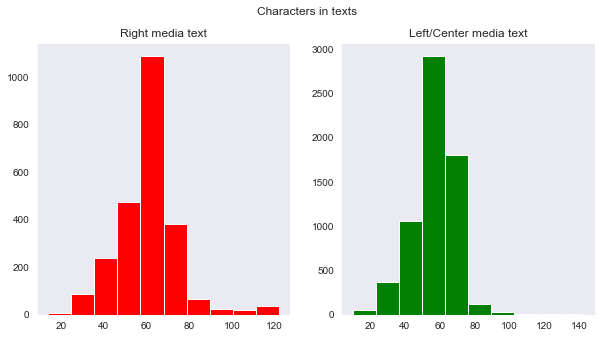

In [29]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
text_len=df[df['is_right']==1]['Title'].str.len()
ax1.hist(text_len,color='red')
ax1.set_title('Right media text')
text_len=df[df['is_right']==0]['Title'].str.len()
ax2.hist(text_len,color='green')
ax2.set_title('Left/Center media text')
fig.suptitle('Characters in texts')
plt.show()

### Number of words in each text

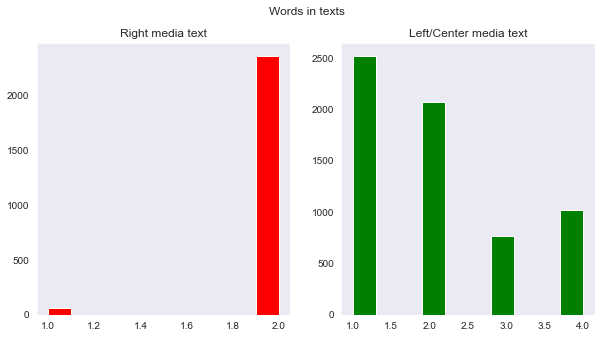

In [30]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
text_len=df[df['is_right']==1]['Source'].str.split().map(lambda x: len(x))
ax1.hist(text_len,color='red')
ax1.set_title('Right media text')
text_len=df[df['is_right']==0]['Source'].str.split().map(lambda x: len(x))
ax2.hist(text_len,color='green')
ax2.set_title('Left/Center media text')
fig.suptitle('Words in texts')
plt.show()

### Average word length in a text

Text(0.5, 0.98, 'Average word length in each text')

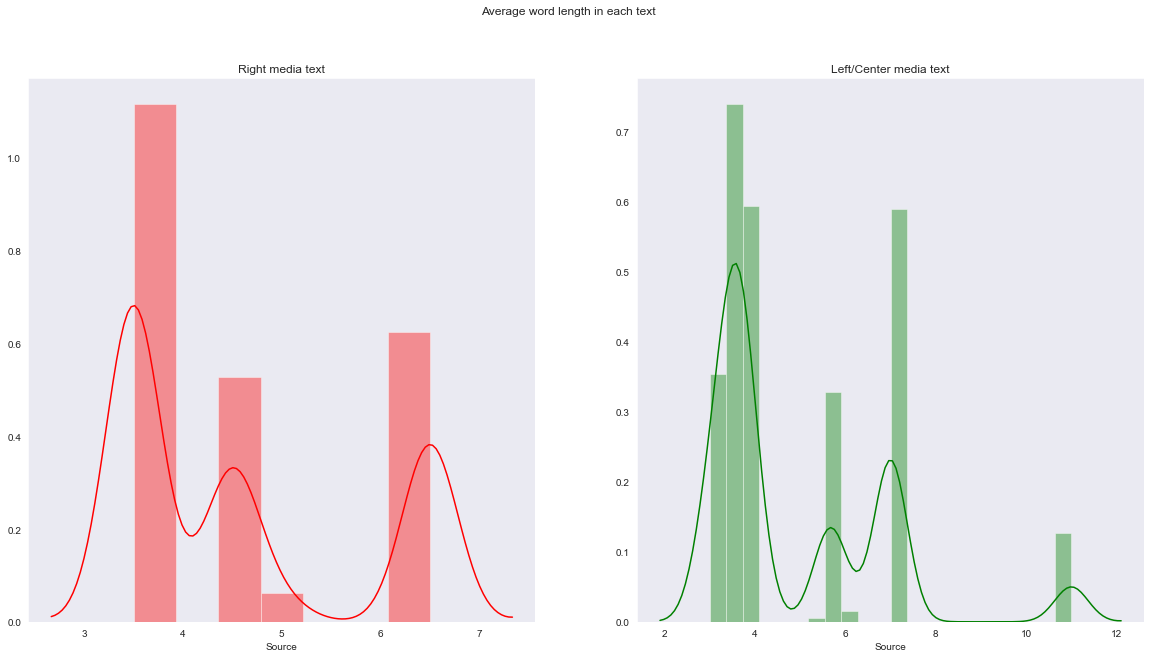

In [31]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(20,10))
word=df[df['is_right']==1]['Source'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='red')
ax1.set_title('Right media text')
word=df[df['is_right']==0]['Source'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2,color='green')
ax2.set_title('Left/Center media text')
fig.suptitle('Average word length in each text')

### Converting text to format acceptable by gensim

In [32]:
words = []
for i in df['Title'].values:
    words.append(i.split())
words[:5]

[['hololens',
  'dev',
  'edition',
  'costs',
  '£2,000',
  'with',
  'new',
  'conker',
  'game'],
 ['obama',
  'encouraging',
  'young',
  'people',
  'to',
  'learn',
  'math,',
  'science'],
 ['first', 'hololens', 'kit', 'to', 'cost', '$3,000'],
 ['microsoft',
  'begins',
  'taking',
  'preorders',
  'from',
  'developers',
  'for',
  'the',
  'hololens'],
 ['the',
  'first-ever',
  'raising',
  'of',
  "palestine's",
  'flag',
  'at',
  'the',
  'un',
  'is',
  'our',
  'moment',
  '...']]

In [33]:
import gensim

#Dimension of vectors we are generating
EMBEDDING_DIM = 100
#Creating Word Vectors by Word2Vec Method (takes time...)
w2v_model = gensim.models.Word2Vec(sentences = words , window = 5 , min_count = 1)

In [34]:
#vocab size
#len(w2v_model.wv.vocab)
len(list(w2v_model.wv.index_to_key))
#We have now represented each of 13535 words by a ndim vector.


13535

In [35]:
tokenizer = text.Tokenizer(num_words=35000)
tokenizer.fit_on_texts(words)
tokenized_train = tokenizer.texts_to_sequences(words)
x = sequence.pad_sequences(tokenized_train, maxlen = 20)

In [36]:
# Adding 1 because of reserved 0 index
# Embedding Layer creates one more vector for "UNKNOWN" words, or padded words (0s). This Vector is filled with zeros.
# Thus our vocab size inceeases by 1
vocab_size = len(tokenizer.word_index) + 1

In [37]:
# Function to create weight matrix from word2vec gensim model
def get_weight_matrix(model, vocab):
    # total vocabulary size plus 0 for unknown words
    vocab_size = len(vocab) + 1
    # define weight matrix dimensions with all 0
    weight_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
    # step vocab, store vectors using the Tokenizer's integer mapping
    for word, i in vocab.items():
        weight_matrix[i] = model.wv[word]
    return weight_matrix

In [38]:
#Getting embedding vectors from word2vec and usings it as weights of non-trainable keras embedding layer
embedding_vectors = get_weight_matrix(w2v_model, tokenizer.word_index)

We use `Word2Vec` technique to create vector representation of each word. With this technique, it takes input text return output as a set of vectors that represent words in that text.Vectors of similar words are grouped together. The order of proximity is measured using `cosine similarity`.

## TRAINING WORD2VEC MODEL

In [39]:
#Defining Neural Network
model = Sequential()
#Non-trainable embeddidng layer
model.add(Embedding(vocab_size, output_dim=EMBEDDING_DIM, weights=[embedding_vectors], input_length=20, trainable=True))
#LSTM 
model.add(Bidirectional(LSTM(units=128 , recurrent_dropout = 0.3 , dropout = 0.3,return_sequences = True)))
model.add(Bidirectional(GRU(units=32 , recurrent_dropout = 0.1 , dropout = 0.1)))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=tf.keras.optimizers.Adam(lr = 0.01), loss='binary_crossentropy', metrics=['acc'])

del embedding_vectors

/Users/Kazage/.local/lib/python3.8/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [40]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 20, 100)           1353600   
_________________________________________________________________
bidirectional (Bidirectional (None, 20, 256)           234496    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                55680     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 1,643,841
Trainable params: 1,643,841
Non-trainable params: 0
_________________________________________________________________


In [42]:
#from sklearn.utils import class_weight
#class_weight = class_weight.compute_class_weight('balanced'
#                                               ,np.unique(y_train)
#                                               ,y_train)

In [43]:
x_train, x_test, y_train, y_test = train_test_split(x, df.is_right , test_size = 0.3 , random_state = 0) 

In [44]:
history = model.fit(x_train, y_train, batch_size = 128 , validation_data = (x_test,y_test) , epochs = 3)

Epoch 1/3
49/49 [==============================] - 30s 367ms/step - loss: 0.6015 - acc: 0.7186 - val_loss: 0.5893 - val_acc: 0.7229
Epoch 2/3
49/49 [==============================] - 16s 326ms/step - loss: 0.4425 - acc: 0.7957 - val_loss: 0.6043 - val_acc: 0.7343
Epoch 3/3
49/49 [==============================] - 16s 335ms/step - loss: 0.1870 - acc: 0.9307 - val_loss: 0.6727 - val_acc: 0.7271


In [45]:
print("Accuracy of the model on Training Data is - " , model.evaluate(x_train,y_train)[1]*100)
print("Accuracy of the model on Testing Data is - " , model.evaluate(x_test,y_test)[1]*100)

193/193 [==============================] - 5s 24ms/step - loss: 0.0918 - acc: 0.9723
Accuracy of the model on Training Data is -  97.22537994384766
83/83 [==============================] - 2s 22ms/step - loss: 0.6727 - acc: 0.7271
Accuracy of the model on Testing Data is -  72.7100670337677


So far the model accuracy is 72.7%

## ANALYSIS AFTER TRAINING OF WORD2VEC MODEL

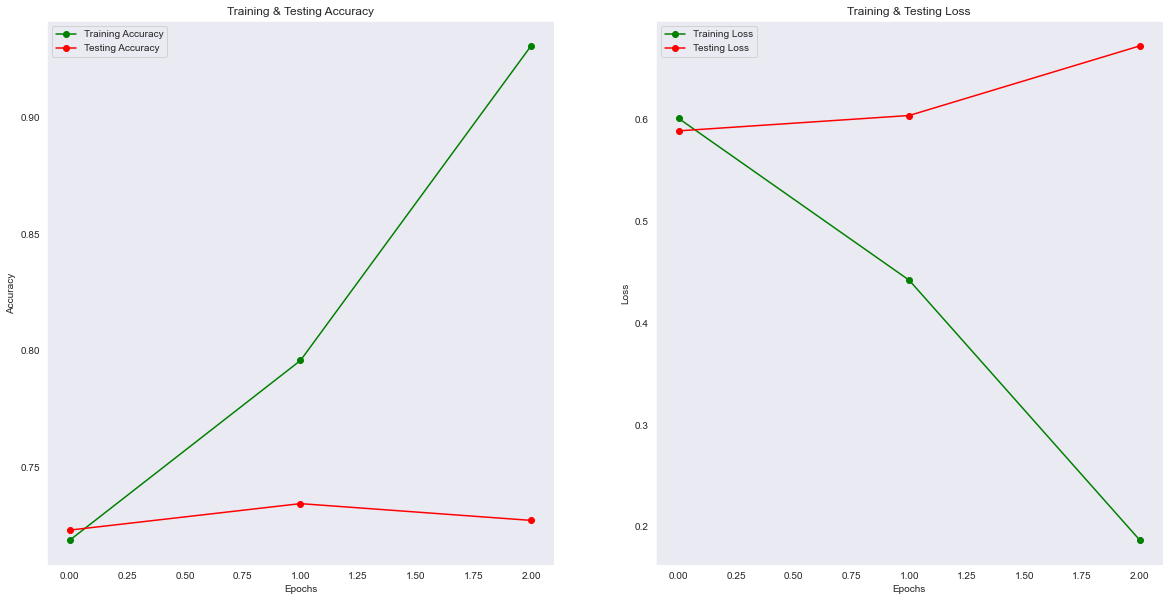

In [46]:
epochs = [i for i in range(3)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['acc']
train_loss = history.history['loss']
val_acc = history.history['val_acc']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Testing Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'go-' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'ro-' , label = 'Testing Loss')
ax[1].set_title('Training & Testing Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

It looks like the model is not performing very well on the test data

In [47]:
y_pred = model.predict(x_test)
y_pred = np.round(y_pred).astype("int32")
y_pred[:5]

array([[0],
       [0],
       [0],
       [0],
       [0]], dtype=int32)

In [48]:
cm = confusion_matrix(y_test,y_pred)
cm

array([[1620,  284],
       [ 437,  301]])

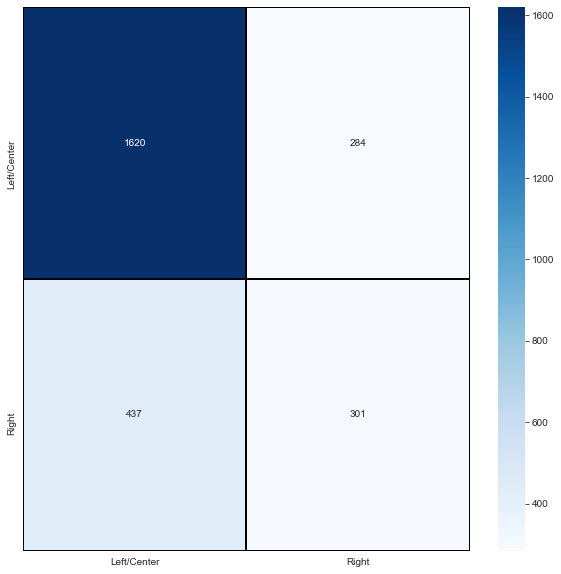

In [49]:
cm = pd.DataFrame(cm , index = ['Left/Center','Right'] , columns = ['Left/Center','Right'])
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = ['Left/Center','Right'] , yticklabels = ['Left/Center','Right'])


In [85]:
print("AUC&ROC:", roc_auc_score(y_test, y_pred))

AUC&ROC: 0.6293497073626199


## GLOVE

While `Word2Vec` model learn their vectors in order to improve the loss of predicting the target words, `GloVe` learn their vectors by doing dimensionality reduction on the count matrix.

In [51]:
x_train,x_test,y_train,y_test = train_test_split(df.Title, df.is_right, test_size = 0.3 , random_state = 0)

In [52]:
max_features = 35000
maxlen = 200

In [53]:
tokenizer = text.Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(x_train)
tokenized_train = tokenizer.texts_to_sequences(x_train)
x_train = sequence.pad_sequences(tokenized_train, maxlen=maxlen)

In [55]:
tokenized_test = tokenizer.texts_to_sequences(x_test)
X_test = sequence.pad_sequences(tokenized_test, maxlen=maxlen)

In [56]:
EMBEDDING_FILE = 'glove.twitter.27B.200d.txt'

In [57]:
def get_coefs(word, *arr): 
    return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.rstrip().rsplit(' ')) for o in open(EMBEDDING_FILE))

In [58]:
all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
embed_size = all_embs.shape[1]

word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index)) + 1
#change below line if computing normal stats is too slow
embedding_matrix = embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

/Users/Kazage/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3263: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if (await self.run_code(code, result,  async_=asy)):


In [59]:
test_pred_proba = model.predict(X_test)

In [60]:
len(x_test) == len(X_test)

True

In [61]:
x_test.head()

273     trump would 'certainly implement' national dat...
2645    bernie sanders doubts he will match obama's 20...
6338                    trump breaks with obama on brexit
5636    letters: why is barack obama interfering in eu...
1285                        obama prepares to act on guns
Name: Title, dtype: object

### BASIC MODEL PARAMETERS

In [62]:
batch_size = 128
epochs = 2
embed_size = 200

## TRAINING GLOVE EMBEDDINGS MODEL

In [63]:
#Defining Neural Network
model = Sequential()
#Non-trainable embeddidng layer
model.add(Embedding(nb_words, output_dim=embed_size, weights=[embedding_matrix], input_length=200, trainable=True))
#model.add(Embedding(input_dim = vocab_size+1, output_dim=embed_size, weights=[embedding_matrix], input_length=200, trainable=True))
#LSTM 
model.add(Bidirectional(LSTM(units=128 , recurrent_dropout = 0.5 , dropout = 0.5)))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=tf.keras.optimizers.Adam(lr = 0.01), loss='binary_crossentropy', metrics=['acc'])

In [64]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 200, 200)          1870200   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 256)               336896    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 2,207,353
Trainable params: 2,207,353
Non-trainable params: 0
_________________________________________________________________


In [65]:
history = model.fit(x_train, y_train, batch_size = batch_size , validation_data = (X_test,y_test) , epochs = 2)

Epoch 1/2
49/49 [==============================] - 158s 3s/step - loss: 0.6059 - acc: 0.7102 - val_loss: 0.5537 - val_acc: 0.7203
Epoch 2/2
49/49 [==============================] - 151s 3s/step - loss: 0.4650 - acc: 0.7865 - val_loss: 0.5687 - val_acc: 0.7305


In [66]:
print("Accuracy of the model on Testing Data is - " , model.evaluate(X_test,y_test)[1]*100)

83/83 [==============================] - 13s 161ms/step - loss: 0.5687 - acc: 0.7305
Accuracy of the model on Testing Data is -  73.05071949958801


The model accuracy improved from 72.7% to 73.05%

### ANALYSIS AFTER TRAINING OF GLOVE EMBEDDINGS MODEL

In [68]:
pred = model.predict(X_test)
pred = np.round(pred).astype("int32")
pred[:5]

array([[0],
       [0],
       [0],
       [0],
       [0]], dtype=int32)

In [69]:
print(classification_report(y_test, pred, target_names = ['Left/Center','Right']))

              precision    recall  f1-score   support

 Left/Center       0.77      0.89      0.83      1904
       Right       0.53      0.32      0.40       738

    accuracy                           0.73      2642
   macro avg       0.65      0.60      0.61      2642
weighted avg       0.70      0.73      0.71      2642



In [70]:
cm = confusion_matrix(y_test,pred)
cm

array([[1694,  210],
       [ 502,  236]])

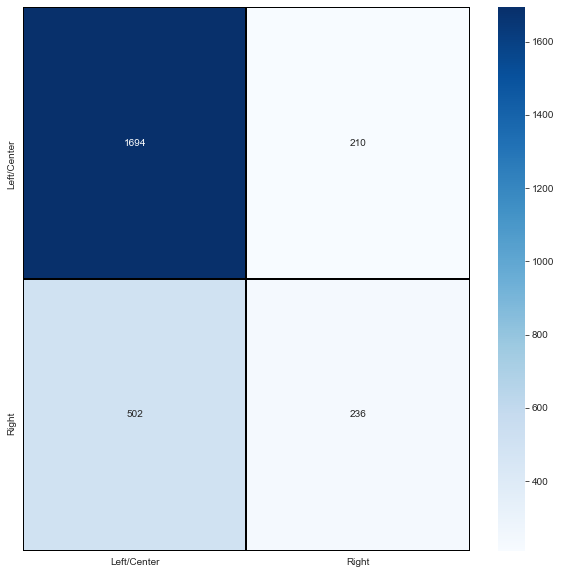

In [71]:
cm = pd.DataFrame(cm , index = ['Left/Center','Right'] , columns = ['Left/Center','Right'])
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = ['Left/Center','Right'] , yticklabels = ['Left/Center','Right'])

In [72]:
average_train = y_train.mean()

In [73]:
# naive model
pred_naive = [average_train] * len(y_test)

In [74]:
from sklearn.metrics import classification_report

In [75]:
print(classification_report(y_test, [i > 0.5 for i in pred_naive]))

              precision    recall  f1-score   support

           0       0.72      1.00      0.84      1904
           1       0.00      0.00      0.00       738

    accuracy                           0.72      2642
   macro avg       0.36      0.50      0.42      2642
weighted avg       0.52      0.72      0.60      2642



/Users/Kazage/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## EVALUATING THE MODEL

### Rudimentary Probling of the Model

In [76]:
def probe_model(headline_text):
    tokenized_text = tokenizer.texts_to_sequences([headline_text])
    padded_text = sequence.pad_sequences(tokenized_text, maxlen=maxlen)
    return model.predict(padded_text)

In [77]:
probe_model('Obama was a muslim ')

array([[0.34954363]], dtype=float32)

In [78]:
probe_model('Trump won')

array([[0.64648527]], dtype=float32)

In [79]:
df_test_eval = pd.DataFrame({'headline':x_test, 'pred_proba': test_pred_proba[:, 0]})

In [80]:
test_pred_proba = model.predict(X_test)

Let's do a rudimentary `test evaluation`. We already know that they word `obama` (and also `trump` why not!) dominates in the right wing media news headlines as well as in left/center news sources. What happens if we build a `prediction probability` (like we did here above) and compare it with the `true label` of the feature? 

In [81]:
df_test_eval = pd.DataFrame({'headline_text': x_test.values,
                             'pred_proba': test_pred_proba[:,0],
                             'true_label': y_test.values})

In [94]:
df_test_eval[(df_test_eval.pred_proba > 0.5) & 
            (~df_test_eval.headline_text.str.contains('obama'))].head(10)

,headline_text,pred_proba,true_label
55,"pompeo speaks with iraq's prime minister, pres...",0.888859,1
103,flashback  glenn beck: john mccain 'worse f...,0.544811,1
131,palestinian journalists facing dual restrictions,0.515737,0
175,amanda review: a sensitive but short-sighted p...,0.615453,0
195,pete hegseth reveals the one thing kim jong un...,0.838605,1
249,donald trump tries to clean up economic comments,0.576981,0
280,jeremy corbyn insists immigration is a good th...,0.601885,1
293,trump threatens ‘ignorant and insulting’ iran ...,0.627113,0
297,murdered mum and baby 'killed by stranger who ...,0.500991,1
300,susanna reid shocked by ‘funeral wrecker’ who’...,0.663951,1


In [83]:
df_test_eval[(df_test_eval.pred_proba < 0.5) & 
            (~df_test_eval.headline_text.str.contains('trump'))].head(10)

,headline_text,pred_proba,true_label
1,bernie sanders doubts he will match obama's 20...,0.441187,0
3,letters: why is barack obama interfering in eu...,0.171649,0
4,obama prepares to act on guns,0.357583,0
5,kushner says mid-east peace can bring prosperity,0.083817,0
6,obama: vast parts of the world now off-limits ...,0.038216,0
7,michelle obama picks 4 designers for white hou...,0.029214,0
8,eu referendum: boris johnson accuses barack ob...,0.244824,0
9,daily mail comment: barack obama is last man w...,0.474519,1
10,"week ahead: obama, gop offer healthcare promis...",0.221907,1
11,the latest: obama at marine base gym on wet ha...,0.042697,0


It looks like our model is doing better at predicting accurately the `true label` in the vast majority of cases. In the first table above we were looking at the `prediction probability` greater than 0.5 and compare them to the `true label` of text which does not contain the word `obama`. Next we were looking at the `prediction probability` greater than 0.5 and compare them to the `true label` of text which does not contain the word `trump`.

### AUC ROC

In [84]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_test))]
# predict probabilities
nn_probs = (model.predict(X_test) > 0.5).astype("int32")

In [86]:
# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
nn_auc = roc_auc_score(y_test, nn_probs)

In [87]:
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('NLP: ROC AUC=%.3f' % (nn_auc))

No Skill: ROC AUC=0.500
NLP: ROC AUC=0.605


In the most surprising way, the `ROC` score did not improve! but at least it is still greater than the naive no skill model. 

In [88]:
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
nn_fpr, nn_tpr, _ = roc_curve(y_test, nn_probs)

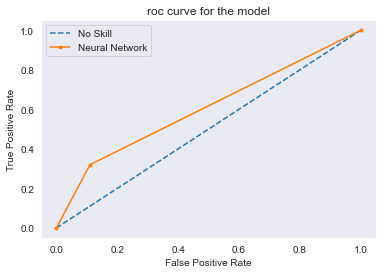

In [89]:
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(nn_fpr, nn_tpr, marker='.', label='Neural Network')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('roc curve for the model')
# show the legend
plt.legend()
# show the plot
plt.show()

In [90]:
print("AUC&ROC:", roc_auc_score(y_test, pred))


AUC&ROC: 0.6047445400924596


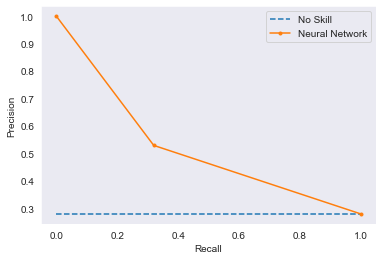

In [92]:
from sklearn.metrics import precision_recall_curve
# calculate precision and recall for each threshold
nn_precision, nn_recall, _ = precision_recall_curve(y_test, nn_probs)
# plot the precision-recall curves
no_skill = len(y_test[y_test==1]) / len(y_test)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
plt.plot(nn_recall, nn_precision, marker='.', label='Neural Network')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# show the plot
plt.show()

## CONCLUSION AND FUTURE WORK

* We used a Word2Vec and GloVe techniques to implement a right wing media detection
* The accuracy improved from 72.7% to 73.05% and the AUC score was better than the no skill model
* We should later use larger or better datasets to retrain the model
* In the future, we can improve our model by filtering better our feature and tuning the parameters more precisely 
* We can use better more state-of-the art techniques like BERT
